In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization
from tensorflow.keras.applications import DenseNet121
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

In [ ]:
data_dir = './Alzheimer_s Dataset/'
IMG_SIZE = (176,176)
EPOCHS = 100

In [ ]:
# Preprocessing the images

for subfolders in os.listdir(data_dir):
    path_sub = os.path.join(data_dir,subfolders)
    for folders in os.listdir(path_sub):
        folder_path = os.path.join(path_sub, folders)
        for index,images in enumerate(os.listdir(folder_path)):
            img_path = os.path.join(folder_path, images)
            new_image = os.path.join(folder_path,f"{folders.lower()}-{index}.jpg")
            os.rename(img_path, new_image)

In [ ]:
images = []
labels = []
for subfolders in os.listdir(data_dir):
    path_sub = os.path.join(data_dir,subfolders)
    for folder in os.listdir(path_sub):
        folder_path = os.path.join(path_sub, folder)
        for index,image in enumerate(os.listdir(folder_path)):
            images.append(os.path.join(folder_path,image))
            labels.append(folder.replace('Demented','_Demented'))
alz_df = pd.DataFrame({"image":images,"label":labels})

In [ ]:
alz_df.head()

,image,label
0,./Alzheimer_s Dataset/test\MildDemented\mildde...,Mild_Demented
1,./Alzheimer_s Dataset/test\MildDemented\mildde...,Mild_Demented
2,./Alzheimer_s Dataset/test\MildDemented\mildde...,Mild_Demented
3,./Alzheimer_s Dataset/test\MildDemented\mildde...,Mild_Demented
4,./Alzheimer_s Dataset/test\MildDemented\mildde...,Mild_Demented


In [ ]:
class_labels = alz_df.label.unique().tolist()
print(class_labels)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'VeryMild_Demented']


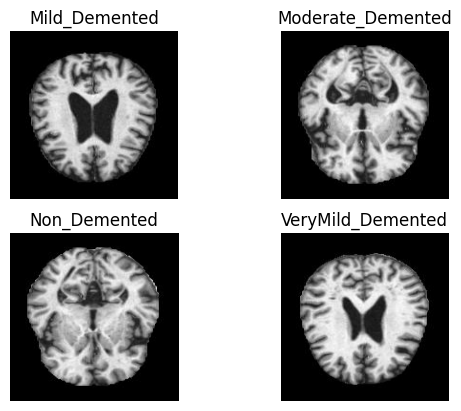

In [ ]:
def show_alz_images():
    fig, ax = plt.subplots(2,2)
    ax = ax.flatten()
    for id, label in enumerate(class_labels):
        img_path = np.random.choice(alz_df.loc[alz_df['label'] == label]['image'])
        image = cv2.imread(img_path)
        image = cv2.resize(image,(176,176))
        ax[id].axis('off')
        ax[id].imshow(image)
        ax[id].set_title(label)
show_alz_images()

In [ ]:
alz_df.shape # Observing of any data fallouts

(6400, 2)

C:\Users\dassh\AppData\Local\Temp\ipykernel_15880\4225890736.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=alz_df, x=labels, palette='inferno')


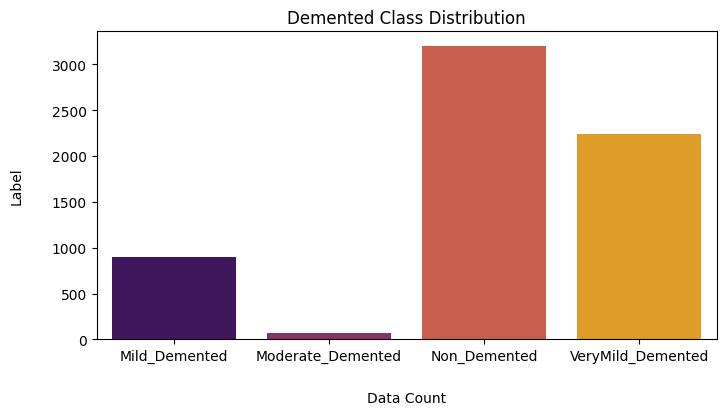

In [ ]:
# Checking the distribution of labels
def plot_label_dist():
    fig = plt.figure(figsize=(8,4)) # figize(length, width)
    sns.countplot(data=alz_df, x=labels, palette='inferno')
    plt.xlabel('Data Count', labelpad=20, fontsize =10)
    plt.ylabel('Label', labelpad=20, fontsize =10)
    plt.title('Demented Class Distribution', loc='center')
    plt.xticks(alz_df.label.unique(), class_labels)
    plt.show()

plot_label_dist()

As we can see on the abpve chart, there is stark contrast in data volume between `Moderate Demented`, `Mild Demented` with rest of the labels. This can result in more false-positives instances which we need to avoid.

In [ ]:
data = ImageDataGenerator(
    rescale = 1./255
)
train_data_gen = data.flow_from_dataframe(alz_df,x_col='image',y_col='label', target_size=IMG_SIZE, batch_size=6500, shuffle=False)

for i in range(len(train_data_gen)):
    train_data, train_labels = train_data_gen[i]

Found 6400 validated image filenames belonging to 4 classes.


In [ ]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176, 176 , 3)
print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [ ]:
# Split the train data into train and test data
train_x, test_x, train_y, test_y = train_test_split(train_data,train_labels, test_size=0.3, random_state=42,shuffle=True,stratify=train_labels)
# Split the test data into validation sets
X_val, test_x1, y_val, test_y1 = train_test_split(test_x,test_y, test_size=0.5, random_state=42,shuffle=True,stratify=test_y)
print('train_x : ' , train_x.shape)
print('test_x1 : ' , test_x1.shape)
print('X_val : ' , X_val.shape)
print('train_y : ' , train_y.shape)
print('test_y1 : ' , test_y1.shape)
print('y_val : ' , y_val.shape)

train_x :  (8960, 176, 176, 3)
test_x1 :  (1920, 176, 176, 3)
X_val :  (1920, 176, 176, 3)
train_y :  (8960, 4)
test_y1 :  (1920, 4)
y_val :  (1920, 4)


In [ ]:
# Define custom callback to stop training when accuracy exceeds 93%
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.93:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True

# Instantiate callbacks
my_callback = MyCallback()

rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

# DenseNet121 Model

In [ ]:
# Load DenseNet121 base model
base_model = DenseNet121(input_shape=(176, 176, 3), include_top=False, weights="imagenet")
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Define custom head for classification
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(4, activation='softmax')(x)  # Assuming 4 classes for classification

# Create custom model
custom_densenet_model = Model(inputs=base_model.input, outputs=output, name="densenet_cnn_model")

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tf.keras.metrics.F1Score(name='f1_score')]

CALLBACKS = [my_callback, rop_callback]

# Compile the model
custom_densenet_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

# Print model summary
custom_densenet_model.summary()

Model: "densenet_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 176, 176,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 182, 182,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 88, 88,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 88, 88,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 88, 88,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 90, 90,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 44, 44,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 44, 44,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 44, 44,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 44, 44,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 44, 44,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 44, 44,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 44, 44,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 44, 44,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 44, 44,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 44, 44,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 44, 44,    │     12,288 │ conv2_block2_0_r

 Total params: 7,742,980 (29.54 MB)

 Trainable params: 701,508 (2.68 MB)

 Non-trainable params: 7,041,472 (26.86 MB)

In [ ]:
# Fit the model to the training data
history = custom_densenet_model.fit(train_x, train_y,validation_data=(X_val, y_val),callbacks=CALLBACKS,epochs=EPOCHS)

Epoch 1/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 179s 578ms/step - acc: 0.4367 - auc: 0.7062 - f1_score: 0.4295 - loss: 1.3179 - val_acc: 0.6844 - val_auc: 0.9115 - val_f1_score: 0.6789 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 2/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 157s 562ms/step - acc: 0.6333 - auc: 0.8849 - f1_score: 0.6320 - loss: 0.7968 - val_acc: 0.7531 - val_auc: 0.9474 - val_f1_score: 0.7464 - val_loss: 0.5421 - learning_rate: 0.0010
Epoch 3/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 156s 559ms/step - acc: 0.6976 - auc: 0.9174 - f1_score: 0.6946 - loss: 0.6778 - val_acc: 0.7937 - val_auc: 0.9597 - val_f1_score: 0.7882 - val_loss: 0.4737 - learning_rate: 0.0010
Epoch 4/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 156s 556ms/step - acc: 0.7258 - auc: 0.9272 - f1_score: 0.7252 - loss: 0.6406 - val_acc: 0.8198 - val_auc: 0.9698 - val_f1_score: 0.8185 - val_loss: 0.4238 - learning_rate: 0.0010
Epoch 5/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 156s 558ms/step - acc: 0.7522 - auc: 0.9434 - f1_score: 0.7532 - loss: 0.56

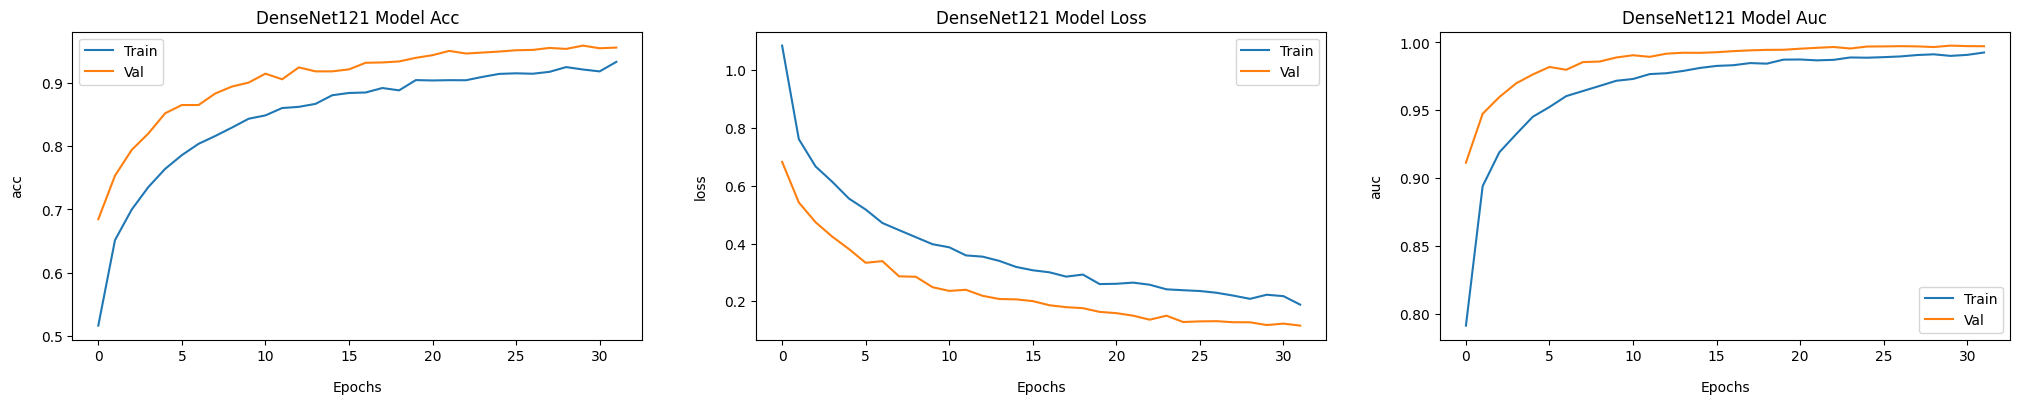

In [ ]:
fig, ax = plt.subplots(1,3,figsize = (25,4))
ax = ax.flatten()
eval_metrics = ['acc','loss','auc']
for i, metric in enumerate(eval_metrics):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title(f'DenseNet121 Model {metric.capitalize()}')
    ax[i].legend(['Train','Val'])
    ax[i].set_xlabel('Epochs', labelpad = 12)
    ax[i].set_ylabel(f'{metric}', labelpad = 12)

In [ ]:
custom_densenet_model.save('./Model/model_v1.keras')

# DensNet121 Evaluation

In [ ]:
test_results = custom_densenet_model.evaluate(test_x,test_y)

120/120 ━━━━━━━━━━━━━━━━━━━━ 57s 472ms/step - acc: 0.9534 - auc: 0.9968 - f1_score: 0.9531 - loss: 0.1210


In [ ]:
model = keras.models.load_model('./Model/model_v1.keras')

In [ ]:
# Predicting classes from the test set
y_pred = model.predict(test_x)

120/120 ━━━━━━━━━━━━━━━━━━━━ 60s 465ms/step


In [ ]:
# Classification report
print(classification_report(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       960
           1       1.00      1.00      1.00       960
           2       0.91      0.93      0.92       960
           3       0.93      0.91      0.92       960

    accuracy                           0.96      3840
   macro avg       0.96      0.96      0.96      3840
weighted avg       0.96      0.96      0.96      3840



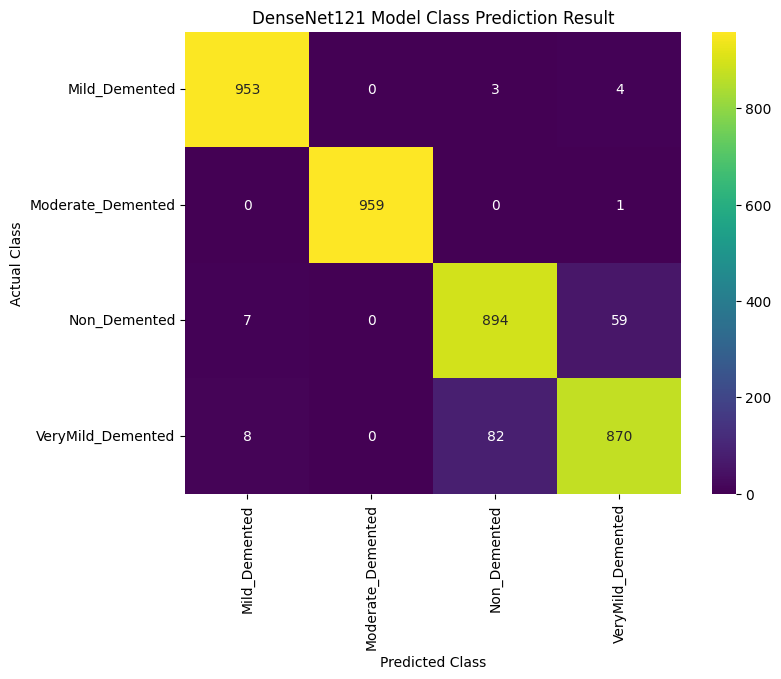

In [ ]:
# Confusion Matrix
def plot_confusion_matrix():
    cnf_mat = confusion_matrix(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1))

    plt.figure(figsize=(8, 6))

    sns.heatmap(cnf_mat, cmap='viridis', annot=True, fmt='d', xticklabels=class_labels,
                    yticklabels=class_labels)

    plt.title("DenseNet121 Model Class Prediction Result")
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.show()

plot_confusion_matrix()